data loaded!
taille train set : 129533
taille validation set : 259065
taille test set : 2202050


If you want to use `CamembertLMHeadModel` as a standalone, add `is_decoder=True.`


training for 3 epochs...
epoch : 1
epoch : 2
epoch : 3
training completion in 0:28:43.466647
training done.



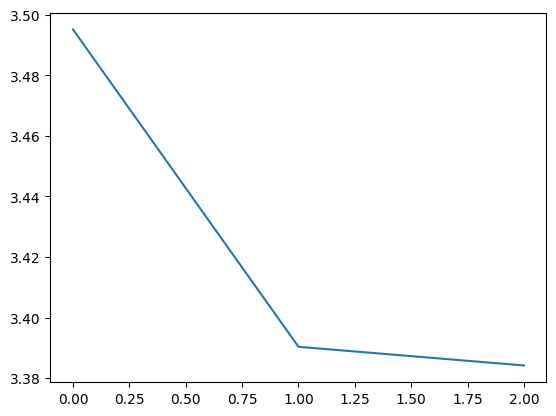

In [11]:
!pip install unidecode
!pip install transformers==4.36.2

import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import AdamW
from transformers import pipeline, CamembertForCausalLM, AutoTokenizer, CONFIG_MAPPING, GPT2LMHeadModel
import os
from unidecode import unidecode
import string
import time
from datetime import timedelta
from matplotlib import pyplot as plt

config = CONFIG_MAPPING["camembert"](vocab_size=32005)

# --- DATASET ---
def get_text_data(root_dir):
    print("preparing data...")
    text_data = []
    for subdir, dirs, files in os.walk(root_dir):
        for file in files:
            if file.endswith('.txt') or file.endswith('.epub'):
                with open(os.path.join(subdir, file), 'r', encoding='utf-8') as f:
                    text_data.extend(f.read().split())
    # remove accents
    text_data = [unidecode(text) for text in text_data]
    # remove punctuation
    SYMBOLS = string.punctuation.replace('-', '').replace("'", "")
    text_data = [text.translate({ord(i): None for i in SYMBOLS}) for text in text_data]
    # split into more words where there is "-" or "'"
    tmp = []
    for txt in text_data:
        if "-" in txt:
            sp = list(filter(lambda x: len(x) > 1, txt.split("-")))
            tmp.extend(sp)
        elif "'" in txt:
            sp = list(filter(lambda x: len(x) > 1, txt.split("'")))
            tmp.extend(sp)
        else:
            if txt == "h": txt = "heures"
            elif txt == "g": txt = "grammes"
            elif txt == "c": continue
            tmp.append(txt)
    text_data = tmp
    # remove empty lines
    text_data = list(filter(lambda x: x != "", text_data))
    # lowercase
    text_data = [text.lower() for text in text_data]
    # write it in output file
    with open("cuisine-dataset.txt", "w", encoding="utf-8") as f:
        f.write("\n".join(text_data))
    print("data prepared! -> cuisine-dataset.txt")
    return text_data

def load_dataset(train_set_ratio=0.8, validation_set_ratio=0.1, test_set_ratio=0.1):
    with open("cuisine-dataset.txt", "r", encoding="utf-8") as f:
        data = f.read().splitlines()
    print("data loaded!")
    return random_split(data, [train_set_ratio, validation_set_ratio, test_set_ratio])

# --- TRAINING ---
def train():
    tokenizer = AutoTokenizer.from_pretrained("camembert-base")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = CamembertForCausalLM(config).to(device)
    model.init_weights()
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    print(f"training for {num_epochs} epochs...")
    start_time = time.time()
    losses = []
    for epoch in range(num_epochs):
        train_err = 0
        print(f"epoch : {epoch+1}")
        for batch in train_loader:
            inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, is_split_into_words=True)
            model.to(device)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(**inputs, labels=inputs["input_ids"])
            loss = outputs.loss
            optimizer.zero_grad()
            loss.backward()
            train_err += loss.item()
            optimizer.step()
        model.to("cpu")
        losses.append(train_err/1000/batch_size)
    completion_time = time.time()
    print(f"training completion in {timedelta(seconds=completion_time - start_time)}")
    model.save_pretrained("my_model")
    tokenizer.save_pretrained("my_model")
    print("training done.\n")
    return losses

# --- USING MODEL ---
def generate_output():
    global config
    config.is_decoder = True
    prompt = "dessert au "
    tokenizer = AutoTokenizer.from_pretrained("my_model")
    model = CamembertForCausalLM.from_pretrained("my_model", config=config)
    model.eval()
    pipe = pipeline("text-generation", model=model, tokenizer=tokenizer, config=config)
    pipeline_output = pipe(prompt, max_length=30, do_sample=True, top_k=100, top_p=0.95)
    return pipeline_output[0]["generated_text"]

def show_losses(losses):
    plt.plot([l for l in losses])
    plt.show()

if __name__ == "__main__":
    num_epochs = 3
    batch_size = 16
    learning_rate = 3e-4
    train_ratio = 0.05
    validation_ratio = 0.1
    test_ratio = 1 - train_ratio - validation_ratio
    train_set, validation_set, test_set = load_dataset(train_ratio, validation_ratio, test_ratio)
    print(f"taille train set : {len(train_set)}")
    print(f"taille validation set : {len(validation_set)}")
    print(f"taille test set : {len(test_set)}")
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    validation_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
    losses = train()
    generate_output()
    show_losses(losses)

In [13]:
for _ in range(5):
  print(f"{generate_output()}")

dessert au  ne dans avec les une se a quez la deait et faites et de en et de sa le a se que la dans les
dessert au  au ne la avec de pre et 2 enes lae de de ou d le avec de  beurre au nee et
dessert au a et a de de puisr le deer este ae la et danss la cette a c
dessert au e une le la sa sa de desees les comme lui la sur le on la de sur eta de de les ca de
dessert au  tout sur a nous  et dans de sel le et sie et les et a a que de qu un lesa


In [3]:
X = unidecode(X_txt)
X = torch.tensor(list(map(ord, X)), dtype=torch.long)
print(X[:10], len(X)), torch.any(X >= 128)

NameError: name 'torch' is not defined

In [ ]:
# we don't define a testset. The model is wayyy too trivial to overfit.

In [ ]:
class Concat(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)

def make_nn(input_features, context_size, hidden_features, output_features):
    return nn.Sequential(
        nn.Embedding(128, input_features),
        Concat(),
        nn.Linear(input_features * context_size, hidden_features),
        nn.ReLU(),
        nn.Linear(hidden_features, hidden_features),
        nn.ReLU(),
        nn.Linear(hidden_features, hidden_features),
        nn.ReLU(),
        nn.Linear(hidden_features, output_features)
    )

batch_size=512
context_size=8
device='cuda'
m = make_nn(32, context_size, 512, 128).to(device)

loss_fn = nn.CrossEntropyLoss()

opt = torch.optim.AdamW(m.parameters(), lr=3e-4, weight_decay=0.01)
losses = []
for epoch in range(500):

    with torch.no_grad():
      print('----')
      for num_completions in range(5):
          s = "\nAujourd'hui"[:context_size]
          for txt_len in range(64):
              as_tensor = torch.tensor(list(map(ord, s[-context_size:]))).cuda()
              logits = m(as_tensor.unsqueeze(0))
              probs = torch.softmax(logits, dim=1)
              new = torch.multinomial(probs, num_samples=1)
              s += chr(new.item())
              del as_tensor
          print(repr(s))

    # we train here
    train_error = 0
    for _ in range(1000):
        letters = torch.stack([
            X[rnd : rnd + context_size + 1]
            for rnd in torch.randint(0, len(X) - context_size - 1, (batch_size,))
        ]).to(device)
        x = letters[:, :-1]
        y = letters[:, -1]

        opt.zero_grad()
        pred = m(x) # [batch, in_features] => [batch, out_features]
        loss = loss_fn(pred, y)
        loss.backward()
        train_error += loss.item()
        opt.step()
    print((epoch+1)*context_size*batch_size, 'k chars | train', train_error / 1000/batch_size)
    losses.append(train_error/1000/batch_size)

    # We test here

In [ ]:
plt.plot([l for l in losses])
plt.show()